In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from tqdm.cli import tqdm

In [2]:
irs_rub = [8.51987757, 8.686113191, 8.904603831, 9.049386475, 9.166205174, 9.162772486, 9.119128004, 9.062602941, 
           9.010157791, 8.959427042, 8.918301511, 8.874426645, 8.839699155, 8.836240603, 8.798502229]
maturity_rub = [3, 6, 9, 12, 2 * 12, 3 * 12, 4 * 12, 5 * 12, 6 * 12, 7 * 12, 8 * 12, 9 * 12, 10 * 12, 12 * 12, 15 * 12, ]

In [3]:
irs_usd = [2.842530622, 2.80778295, 2.794769102, 2.786721861, 2.781489328, 2.764748579, 2.743857526, 2.722993319, 2.707509663, 
           2.692781425, 2.68063008, 2.671503026, 2.666861954, 2.66005416, 2.670453675, 2.684995121, 2.705259845, 2.729940968, 
           2.756197693, 2.78172399, 2.804673005, 2.822751845, 2.857914004, 2.875603381, 2.867861441, 2.853163606, ]
maturity_usd = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 4 * 12, 5 * 12, 6 * 12, 7 * 12, 8 * 12, 9 * 12, 10 * 12, 
                11 * 12, 12 * 12, 15 * 12, 20 * 12, 25 * 12, 30 * 12, ]

Интерполируем имеющуюся короткую процентную ставку

In [4]:
def interpolate_irs(maturity, irs, maturity_min, maturity_max, maturity_dt, currency, plot=True):
    f = interpolate.PchipInterpolator(maturity, irs, extrapolate=True)
    maturity_new = np.arange(maturity_min, maturity_max, maturity_dt)
    irs_new = f(maturity_new)
    if plot:
        plt.figure(figsize=(12, 6))
        plt.scatter(maturity, irs)
        plt.plot(maturity_new, irs_new)
        plt.title(f'Интерполяция короткой процентной ставки {currency}')
        plt.xlabel('Месяц')
        plt.ylabel(f'Короткая процентная ставка {currency}')
        plt.show()
    return maturity_new, irs_new

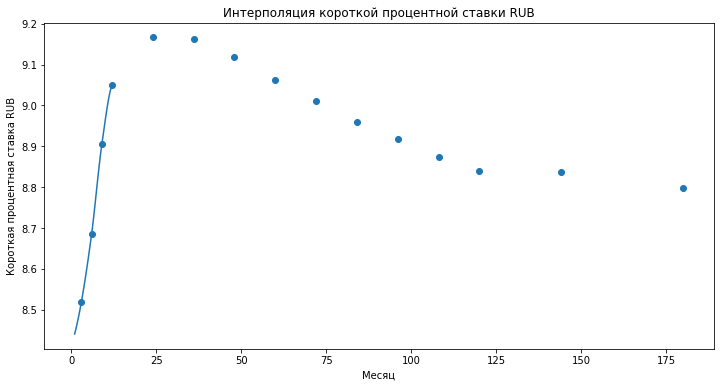

In [113]:
# здесь пока прогноз на каждую неделю года
maturity_rub_new, irs_rub_new = interpolate_irs(maturity_rub, irs_rub, 1, 1 * 12, 1/4, 'RUB')

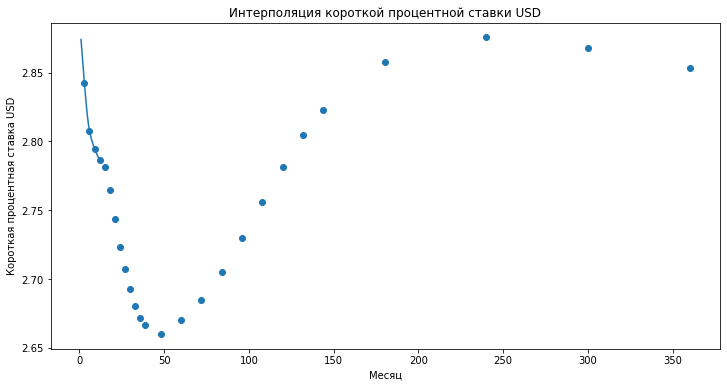

In [114]:
maturity_usd_new, irs_usd_new = interpolate_irs(maturity_usd, irs_usd, 1, 1 * 12, 1/4, 'USD')

Определим коэффициент $\theta$ с помощью разностной схемы

$\cfrac{r_j - r_{j - 1}}{\delta t} + \alpha r_{j-1} = \theta_{j-1}$

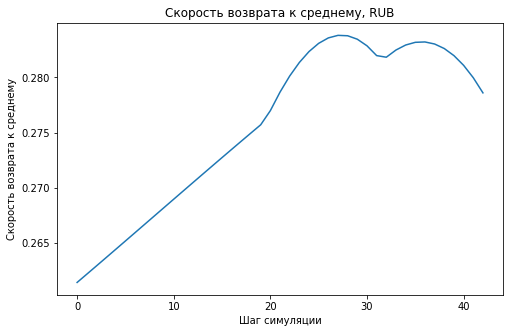

In [162]:
dt = 1 / (15 * 12 * 4 - 1)
T = np.arange(1, 15 * 12, 1/4)
alpha_rub = 0.03
sigma_rub = 0.03
theta_rub = (irs_rub_new[1:] - irs_rub_new[:-1]) + alpha_rub * irs_rub_new[:-1]
# по аналитической формуле получается анлогично
# theta_rub = irs_rub_new[1:] - irs_rub_new[:-1] + alpha_rub * irs_rub_new[:-1] + (sigma_rub ** 2) * (1 - np.exp(-2 * alpha_rub * T[:-1])) / (2 * alpha_rub)
plt.figure(figsize=(8, 5))
plt.plot(theta_rub)
plt.title('Скорость возврата к среднему, RUB')
plt.xlabel('Шаг симуляции')
plt.ylabel('Скорость возврата к среднему')
plt.show()

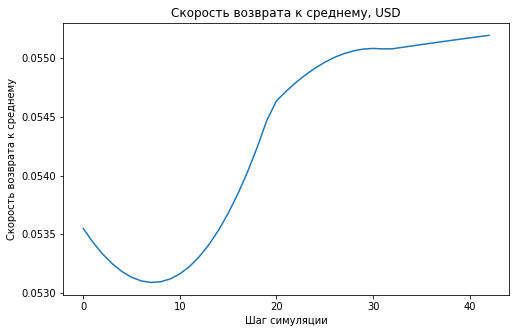

In [163]:
alpha_usd = 0.02
sigma_usd = 0.0093
theta_usd = (irs_usd_new[1:] - irs_usd_new[:-1]) + alpha_usd * irs_usd_new[:-1]
# theta_usd = irs_usd_new[1:] - irs_usd_new[:-1] + alpha_usd * irs_usd_new[:-1] + (sigma_usd ** 2) * (1 - np.exp(-2 * alpha_usd * T[:-1])) / (2 * alpha_usd)
plt.figure(figsize=(8, 5))
plt.plot(theta_usd)
plt.title('Скорость возврата к среднему, USD')
plt.xlabel('Шаг симуляции')
plt.ylabel('Скорость возврата к среднему')
plt.show()

Определим матрицу корреляций (это матрица 3х3)

### Симуляция риск факторов

Зная коэффициент $\theta$, проведем симуляции коротких процентных ставок с помощью разностной схемы

$r_j = r_{j - 1} + (\theta_{j - 1} + \alpha r_{j - 1}) \delta t + \sigma dW_j$

Далее, используя полученные процентные ставки, вычислим обменный курс по формуле:

$fx_j = fx_{j - 1} + (r_{f_{j-1}} - r_{d_{j-1}} + \lambda) \delta t + \sigma dW_j$

In [164]:
# симуляции пока без корреляций
eps = 0.005 # порог для относительного изменения 95 квантили
T = len(theta_rub)
N = 100 # начальное количество симуляций
irs_rub_sim_all = []
irs_usd_sim_all = []
fx_sim_all = []
sigma_fx = 0.11
lam = 0.015
sim_diff_old = [0, 0, 0]
sim_diff_new = [1, 1, 1]
# критерий останова по симуляциям
while any([abs(sim_diff_old[0] / sim_diff_new[0] - 1) > eps,
           abs(sim_diff_old[1] / sim_diff_new[1] - 1) > eps,
           abs(sim_diff_old[2] / sim_diff_new[2] - 1) > eps]):
    for n in tqdm(range(N), total=N):
        irs_rub_sim = [irs_rub[0]]
        irs_usd_sim = [irs_usd[0]]
        fx_sim = [69.17]
        for t in range(T-1):
            irs_rub_sim.append(irs_rub_sim[t] + (theta_rub[t] + alpha_rub * irs_rub_sim[t]) * dt + sigma_rub * np.random.normal(loc=0, scale=1))
            irs_usd_sim.append(irs_usd_sim[t] + (theta_usd[t] + alpha_usd * irs_usd_sim[t]) * dt + sigma_usd * np.random.normal(loc=0, scale=1))
            # для fx пока неточная формула
            fx_sim.append(fx_sim[t] + (irs_usd_sim[t] - irs_rub_sim[t] + lam) * dt + sigma_fx * np.random.normal(loc=0, scale=1))
        irs_rub_sim_all.append(irs_rub_sim)
        irs_usd_sim_all.append(irs_usd_sim)
        fx_sim_all.append(fx_sim)
    sim_diff_old = sim_diff_new
    sim_diff_new = [max(np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0)),
                    max(np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0)),
                    max(np.quantile(np.diff(fx_sim_all), q=0.95, axis=0))
                   ]

100%|██████████| 100/100 [00:00<00:00, 1612.80it/s]


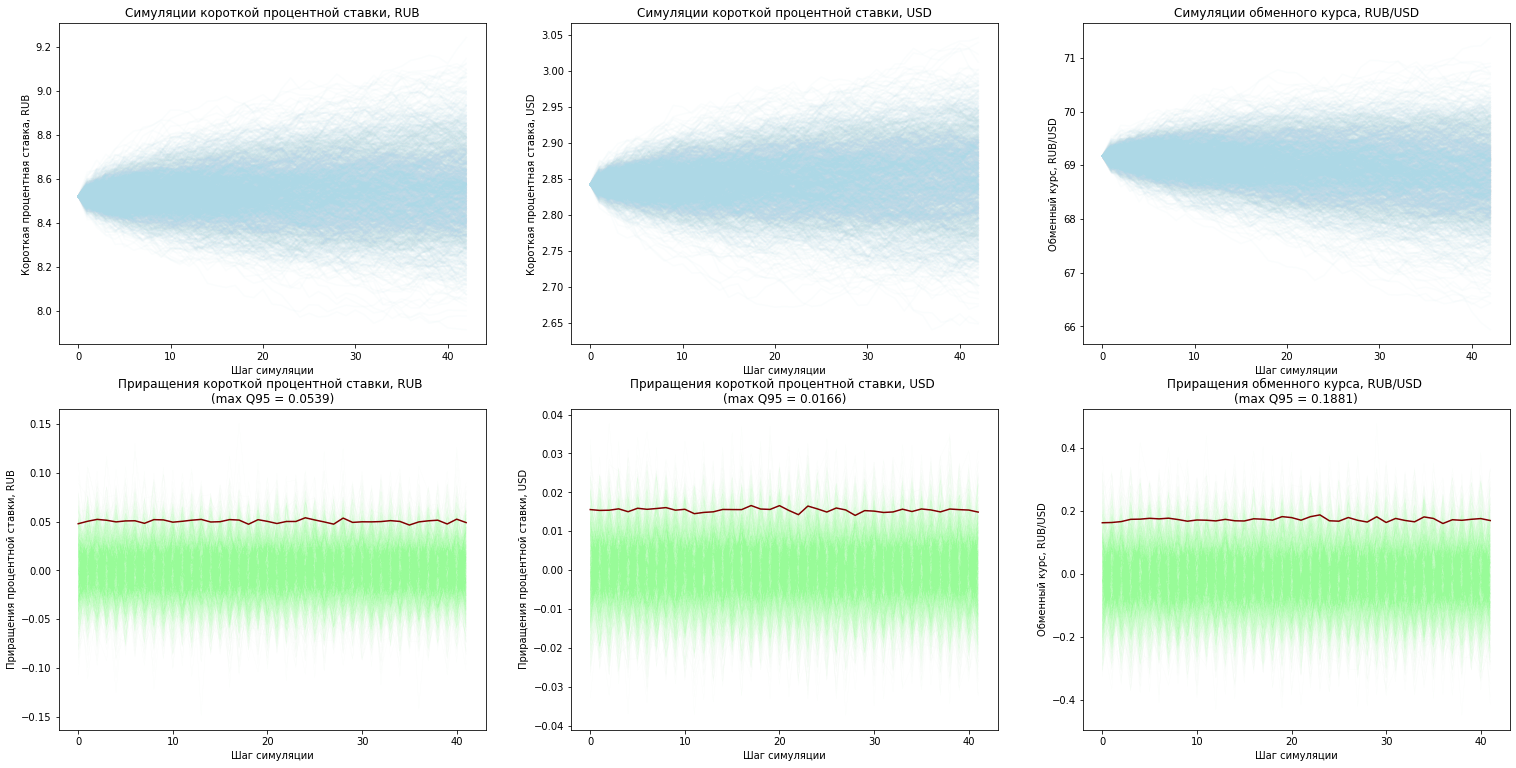

In [172]:
fig, axs = plt.subplots(2, 3, figsize=(26, 13), )

axs[0, 0].plot(range(T), np.array(irs_rub_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 0].set_title('Симуляции короткой процентной ставки, RUB')
axs[0, 0].set_ylabel('Короткая процентная ставка, RUB')
axs[0, 0].set_xlabel('Шаг симуляции')

axs[1, 0].plot(range(T-1), np.diff(irs_rub_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 0].plot(range(T-1), np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 0].set_title(f'Приращения короткой процентной ставки, RUB \n(max Q95 = {round(max(np.quantile(np.diff(irs_rub_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 0].set_ylabel('Приращения процентной ставки, RUB')
axs[1, 0].set_xlabel('Шаг симуляции')

axs[0, 1].plot(range(T), np.array(irs_usd_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 1].set_title('Симуляции короткой процентной ставки, USD')
axs[0, 1].set_ylabel('Короткая процентная ставка, USD')
axs[0, 1].set_xlabel('Шаг симуляции')

axs[1, 1].plot(range(T-1), np.diff(irs_usd_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 1].plot(range(T-1), np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 1].set_title(f'Приращения короткой процентной ставки, USD \n(max Q95 = {round(max(np.quantile(np.diff(irs_usd_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 1].set_ylabel('Приращения процентной ставки, USD')
axs[1, 1].set_xlabel('Шаг симуляции')

axs[0, 2].plot(range(T), np.array(fx_sim_all).T, alpha=0.05, c='lightblue')
axs[0, 2].set_title('Симуляции обменного курса, RUB/USD')
axs[0, 2].set_ylabel('Обменный курс, RUB/USD')
axs[0, 2].set_xlabel('Шаг симуляции')

axs[1, 2].plot(range(T-1), np.diff(fx_sim_all, axis=1).T, alpha=0.05, c='palegreen', linewidth=0.3)
axs[1, 2].plot(range(T-1), np.quantile(np.diff(fx_sim_all), q=0.95, axis=0), label='Q95', c='maroon')
axs[1, 2].set_title(f'Приращения обменного курса, RUB/USD \n(max Q95 = {round(max(np.quantile(np.diff(fx_sim_all), q=0.95, axis=0)), 4)})')
axs[1, 2].set_ylabel('Обменный курс, RUB/USD')
axs[1, 2].set_xlabel('Шаг симуляции')
plt.show()

### Симуляция валютного форварда


Используем ранее полученный обменный курс

Вопросы:

1) почему винеровский процеес нужно генерить из std нормального распределения - иначе получается явный тренд

2) почему 95 квантиль берем из приращений